In [1]:
ls

Bc_epitopes_HLA_overlap-05-06-20.txt
HLA_freq_formated.txt
Select vaccine peptides.ipynb
Window_15mer-05-06-20.txt
Window_15mer-05-07-20.csv
Window_15mer-05-08-20.csv
Window_21mer-05-06-20.txt
Window_21mer-05-07-20.csv
Window_21mer-05-08-20.csv
Window_27mer-05-06-20.txt
Window_27mer-05-07-20.csv
Window_27mer-05-08-20.csv
selected-bcell-cd4-15mer.csv
selected-bcell-cd4-21mer.csv
selected-bcell-cd4-27mer.csv
selected-bcell-cd4-h2b-15mer.csv
selected-bcell-cd4-h2b-21mer.csv
selected-bcell-cd4-h2b-27mer.csv
selected-bcell-cd4-h2d-15mer.csv
selected-bcell-cd4-h2d-21mer.csv
selected-bcell-cd4-h2d-27mer.csv
selected-bcell-vaccine-15mer.csv
selected-bcell-vaccine-21mer.csv
selected-bcell-vaccine-27mer.csv
selected-tcell-cd4-15mer.csv
selected-tcell-cd4-21mer.csv
selected-tcell-cd4-27mer.csv
selected-tcell-cd4-cd8-15mer.csv
selected-tcell-cd4-cd8-21mer.csv
selected-tcell-cd4-cd8-27mer.csv
selected-tcell-cd4-cd8-h2b-15mer.csv
selected-tcell-cd4-cd8-h2b-21mer.csv
selected-tcell-cd4-cd8-h2b-27mer.

In [2]:
df_15mer = pd.read_csv("Window_15mer-05-08-20.csv")
df_21mer = pd.read_csv("Window_21mer-05-08-20.csv")
df_27mer = pd.read_csv("Window_27mer-05-08-20.csv")


In [3]:
extremely_unstable_dipeptides_unc = {
  "DG",
  "NG",
}
problematic_dipeptides_unc = {
   "DS", 
   "DN", 
   "DD", 
   "NN", 
   "ND", 
   "NS",
}

problematic_dipeptides_jpt = {"NP"}

problematic_dipeptides = problematic_dipeptides_unc.union(problematic_dipeptides_jpt)

In [4]:
hydropathy_dict = {
    "A": 1.8,
    "C": 2.5,
    "D": -3.5,
    "E": -3.5,
    "F": 2.8,
    "G": -0.4,
    "H": -3.2,
    "I": 4.5,
    "K": -3.9,
    "L": 3.8,
    "M": 1.9,
    "N": -3.5,
    "P": -1.6,
    "Q": -3.5,
    "R": -4.5,
    "S": -0.8,
    "T": -0.7,
    "V": 4.2,
    "W": -0.9,
    "Y": -1.3
}

In [5]:

def gravy_score(amino_acids):
    """
    Mean amino acid hydropathy averaged across residues of a peptide
    or protein sequence.
    """
    total = 0 
    for aa in amino_acids:
        total += hydropathy_dict[aa]
    return total / len(amino_acids)


In [6]:

def max_kmer_gravy_score(amino_acids, k):
    """
    Returns max GRAVY score of any kmer in the amino acid sequence,
    used to determine if there are any extremely hydrophobic regions within a
    longer amino acid sequence.
    """
    return max(
        gravy_score(amino_acids[i:i + k])
        for i in range(len(amino_acids) - k + 1))


In [7]:
def max_short_subsequence_gravy_score(amino_acids):
    gravy_scores = [
        max_kmer_gravy_score(amino_acids, k)
        for k in [5, 6, 7, 8]
    ]
    return max(gravy_scores)


In [8]:


def difficult_c_terminal(amino_acids):
    return amino_acids[-1] in {"P", "C", "H"}

def difficult_n_terminal(amino_acids):
    """
    Is the N-terminus one of {Gln, Glu, Cys}?
    ---
    Priority I: avoid N-terminal Gln, Glu, Cys
    Priority II: Asparagine at the N-terminus of a peptide is also hard
    to synthesize, though not as bad as {Gln, Glu, Cys}
    """
    return amino_acids[0] in {"Q", "E", "C", "N"}


def cysteine_count(amino_acids):
    """
    How many cysteines are in the amino acid sequence?
    Problem with cysteine residues: They can form disulfide bonds across
    distant parts of the peptide
    """
    return amino_acids.count("C")

def methionine_count(amino_acids):
    """
    How many methionies?
    """
    return amino_acids.count("M")

def thiol_count(amino_acids):
    return cysteine_count(amino_acids) + methionine_count(amino_acids)

def num_extremely_unstable_dipeptides(amino_acids):
    total = 0
    for dipeptide in extremely_unstable_dipeptides_unc:
        total += amino_acids.count(dipeptide)
    return total
    extremely_unstable_dipeptides_unc

def num_moderately_unstable_dipeptides(amino_acids):
    total = 0
    for dipeptide in problematic_dipeptides_unc.union(problematic_dipeptides_jpt):
        total += amino_acids.count(dipeptide)
    return total

In [9]:
def annotate_manufacturability(df):
    df = df.copy()
    df["num_extremely_unstable_dipeptides"] = df.Sequence.map(num_extremely_unstable_dipeptides)
    df["num_moderately_unstable_dipeptides"] = df.Sequence.map(num_moderately_unstable_dipeptides)
    df["num_cysteines"] = df.Sequence.map(cysteine_count)
    df["num_methionines"] = df.Sequence.map(methionine_count)
    df["num_thiols"] = df.Sequence.map(thiol_count)
    df["difficult_c_terminal"] = df.Sequence.map(difficult_c_terminal)
    df["difficult_n_terminal"] = df.Sequence.map(difficult_n_terminal)
    df["gravy"] = df.Sequence.map(gravy_score)
    df["max_kmer_gravy"] = df.Sequence.map(max_short_subsequence_gravy_score)
    df["extreme_local_hydrophobicity"] = df.max_kmer_gravy > 2.5
    df["difficult_local_hydrophobicity"] = df.max_kmer_gravy > 1.5
    df["too_many_cysteines"] = df.num_cysteines > 1
    df["manufacturability_difficulty_score"] = (
        1.0  * (df.gravy > 2.0) +        # hydrophobicity of whole peptide
        1.0 * df.difficult_n_terminal +  # lowest priority: N-terminal residues
        2.0 * df.difficult_c_terminal + 
        2.0 * df.num_thiols + 
        2.0 * df.difficult_local_hydrophobicity + 
        3.0 * df.num_moderately_unstable_dipeptides + 
        5.0 * df.too_many_cysteines +          # disulfide bonds
        10.0 * df.extreme_local_hydrophobicity + 
        10.0 * df.num_extremely_unstable_dipeptides 
    )
    return df

df_27mer_annot = annotate_manufacturability(df_27mer);
df_27mer_annot.to_csv("vaccine-peptides-27mer-annotated-05-07-20.csv", index=False)
df_21mer_annot = annotate_manufacturability(df_21mer);
df_21mer_annot.to_csv("vaccine-peptides-21mer-annotated-05-07-20.csv", index=False)
df_15mer_annot = annotate_manufacturability(df_15mer)
df_15mer_annot.to_csv("vaccine-peptides-15mer-annotated-05-07-20.csv", index=False)




In [10]:
df_concat = pd.concat([
    df_15mer_annot,
    df_21mer_annot,
    df_27mer_annot,
])
df_concat["Length"] = df_concat.Sequence.str.len()

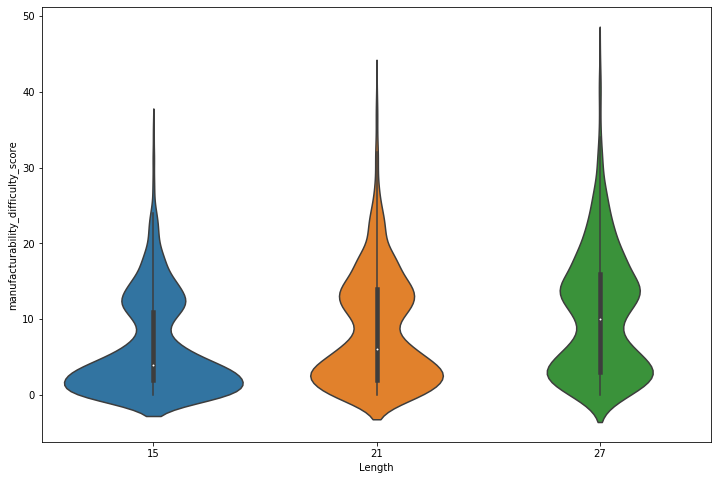

In [11]:
import seaborn 
import matplotlib 
from matplotlib import pyplot
fig = pyplot.figure(figsize=(12,8))

seaborn.violinplot(data=df_concat, x="Length", y="manufacturability_difficulty_score")

In [12]:
bcell_epitopes = pd.read_csv("../bcell/accessible-linear-bcell-epitopes-grouped-merged-filtered.csv", index_col=0)

In [13]:
bcell_epitopes

,num_sources,sources,accessible_subsequence_start,accessible_subsequence_end,accessible_subsequence,accessible_subsequence_length,accessible_subsequence_is_4mer_or_longer,IgG,IgA,IgG_and_IgA,accessible_subsequence_contains_polymorphism,accessible_subsequence_contains_glycosite,near_any_feature,in_any_feature
9,3,Wang 2020 S456-460; Dahlke 2020 S449-463; Char...,457,473,RKSNLKPFERDISTEIY,17,True,True,True,True,False,False,True,True
12,4,Charite 2020 S569-583; Charite 2020 S571-585; ...,580,583,QTLE,4,True,True,True,True,False,False,True,False
17,6,Poh 2020 S809-826; Wang 2020 S806-820; Charite...,809,812,PSKP,4,True,True,True,True,False,False,True,False
21,2,Dahlke 2020 S1131-1145; Charite 2020 S1141-1155,1142,1146,QPELD,5,True,True,True,True,False,False,True,False


In [14]:

from collections import OrderedDict

def annotate_overlapping_bcell_epitopes(df, bcell_epitopes):
    cols = OrderedDict([
        ("overlapping_bcell_epitope", []),
        ("overlapping_bcell_epitope_start", []),
        ("overlapping_bcell_epitope_end", []),
        ("overlapping_bcell_epitope_length", []),
        ("fraction_of_full_bcell_epitope", []),
        ("full_bcell_epitope", []),
    ])

    for (prot, start, end) in zip(df_concat.Protein, df_concat.Start, df_concat.End):
        found_bcell_epitope = False
        if prot == "S":
            for (epitope, epitope_start, epitope_end) in zip(
                    bcell_epitopes.accessible_subsequence,
                    bcell_epitopes.accessible_subsequence_start,
                    bcell_epitopes.accessible_subsequence_end):
                if end >= epitope_start and start <= epitope_end:
                    found_bcell_epitope = True
                    overlap_start = max(epitope_start, start)
                    overlap_end = min(epitope_end, end)
                    overlap_length = overlap_end - overlap_start + 1
                    overlapping_bcell_epitope = epitope[
                        overlap_start - epitope_start:
                        overlap_end - epitope_start + 1]
                    overlap_percent_of_full_bcell_epitope = overlap_length / len(epitope)

                    cols["overlapping_bcell_epitope"].append(overlapping_bcell_epitope)
                    cols["overlapping_bcell_epitope_start"].append(overlap_start)
                    cols["overlapping_bcell_epitope_end"].append(overlap_end)
                    cols["overlapping_bcell_epitope_length"].append(overlap_length)
                    cols["fraction_of_full_bcell_epitope"].append(overlap_percent_of_full_bcell_epitope)
                    cols["full_bcell_epitope"].append(epitope)
                    break
        if not found_bcell_epitope:
            cols["overlapping_bcell_epitope"].append(None)
            cols["overlapping_bcell_epitope_start"].append(None)
            cols["overlapping_bcell_epitope_end"].append(None)
            cols["overlapping_bcell_epitope_length"].append(0)
            cols["fraction_of_full_bcell_epitope"].append(0.0)
            cols["full_bcell_epitope"].append(None)
        
    df_with_bcell_epitopes = df.copy()
    for (col_name, col_values) in cols.items():
        df_with_bcell_epitopes[col_name] = col_values
    return df_with_bcell_epitopes

df_with_bcell_epitopes = annotate_overlapping_bcell_epitopes(df_concat, bcell_epitopes);
df_with_bcell_epitopes

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,difficult_local_hydrophobicity,too_many_cysteines,manufacturability_difficulty_score,Length,overlapping_bcell_epitope,overlapping_bcell_epitope_start,overlapping_bcell_epitope_end,overlapping_bcell_epitope_length,fraction_of_full_bcell_epitope,full_bcell_epitope
0,MFVFLVLLPLVSSQC,S,1,15,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,19.0,15,None,NaN,NaN,0,0.0,None
1,FVFLVLLPLVSSQCV,S,2,16,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,15.0,15,None,NaN,NaN,0,0.0,None
2,VFLVLLPLVSSQCVN,S,3,17,NaN,NaN,0.0,VFLVLLPLVSSQCVN,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
3,FLVLLPLVSSQCVNL,S,4,18,NaN,NaN,0.0,FLVLLPLVSSQCVNL,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
4,LVLLPLVSSQCVNLT,S,5,19,NaN,NaN,0.0,LVLLPLVSSQCVNLT,HLA-DRB1*01:01,0.130464,...,True,False,14.0,15,None,NaN,NaN,0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,DSTQAMGYINVFAFPFTIYSLLLCRMN,N,415,441,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1910,STQAMGYINVFAFPFTIYSLLLCRMNS,N,416,442,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1911,TQAMGYINVFAFPFTIYSLLLCRMNSR,N,417,443,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,21.0,27,None,NaN,NaN,0,0.0,None
1912,QAMGYINVFAFPFTIYSLLLCRMNSRN,N,418,444,NaN,NaN,0.0,NaN,NaN,0.000000,...,True,False,22.0,27,None,NaN,NaN,0,0.0,None


In [15]:
print(df_concat.columns)

Index(['Sequence', 'Protein', 'Start', 'End', 'HLA-I_peptides',
       'HLA-I_haplotypes', 'HLA-I_pop_freq', 'HLA-II_peptides',
       'HLA-II_haplotypes', 'HLA-II_pop_freq', 'Mouse MHC-I b',
       'Mouse MHC-I d', 'Mouse MHC-II b', 'Mouse MHC-II d', 'Total_frequency',
       'num_extremely_unstable_dipeptides',
       'num_moderately_unstable_dipeptides', 'num_cysteines',
       'num_methionines', 'num_thiols', 'difficult_c_terminal',
       'difficult_n_terminal', 'gravy', 'max_kmer_gravy',
       'extreme_local_hydrophobicity', 'difficult_local_hydrophobicity',
       'too_many_cysteines', 'manufacturability_difficulty_score', 'Length'],
      dtype='object')


In [16]:
df_accessibility = pd.read_csv("../solvent-accessibility/Woods-Glycans-MD-Site-Specific-Accessibility.csv");
df_accessibility

,Residue Proper Numbering,SiteSpecific Accessiblity,Nude Accessibility,Difference
0,27,0.94,0.99,0.05
1,28,0.99,1.00,0.01
2,29,0.15,0.26,0.11
3,30,0.36,0.76,0.40
4,31,0.00,0.00,0.00
...,...,...,...,...
1115,1142,0.78,0.89,0.11
1116,1143,0.66,0.70,0.04
1117,1144,0.78,0.79,0.01
1118,1145,0.85,0.86,0.00


In [17]:

def num_contiguous_accessible_residues(protein, start, end, aa_num_to_accessibility, cutoff=0.2):
    if protein != "S":
        return 0
    kmers = []
    curr_kmer = 0
    for aa_num in range(start, end + 1):
        accessibility = aa_num_to_accessibility.get(aa_num, 0)
        if accessibility >= cutoff:
            curr_kmer += 1
        elif curr_kmer > 0:
            kmers.append(curr_kmer)
            curr_kmer = 0
    if curr_kmer > 0:
        kmers.append(curr_kmer)
    if len(kmers) == 0:
        return 0
    else:
        return max(kmers)

def annotate_accesibility(df, cutoff=0.2):
    df = df.copy()
    df_accessibility = pd.read_csv("../solvent-accessibility/Woods-Glycans-MD-Site-Specific-Accessibility.csv");
    aa_num_to_accessibility = dict(
        zip(df_accessibility["Residue Proper Numbering"], 
            df_accessibility["SiteSpecific Accessiblity"]))
    
    df["longest_contiguous_accessible_region_in_spike"] = [
        num_contiguous_accessible_residues(p, s, e, aa_num_to_accessibility, cutoff=cutoff)
        for (p, s, e) in zip(df.Protein, df.Start, df.End)
    ]
    df["max_accessibility"] = [
        max([aa_num_to_accessibility.get(aa_num, 0) for aa_num in range(s, e + 1)])
        if p == "S"
        else 0
        for (p, s, e) in zip(df.Protein, df.Start, df.End)
    ]
    return df

def annotate_selection_criteria(df, rounding_decimals=2):
    df = df.copy()
    df["manufacturability_feasibility_score"] = 2.0 ** (
        -df.manufacturability_difficulty_score / 10.0)
    df["has mouse MHC-I b"] = ~df["Mouse MHC-I b"].isnull()
    df["has mouse MHC-II b"] = ~df["Mouse MHC-II b"].isnull()
    df["has mouse MHC-I d"] = ~df["Mouse MHC-I d"].isnull()
    df["has mouse MHC-II d"] = ~df["Mouse MHC-II d"].isnull()
    df["mouse H2-b count"] = (
        df["has mouse MHC-I b"].astype(int) + 
        df["has mouse MHC-II b"].astype(int) 
    )
    df["mouse H2-d count"] = (
        df["has mouse MHC-I d"].astype(int) + 
        df["has mouse MHC-II d"].astype(int) 
    )
    df["mouse class I count"] = (
        df["has mouse MHC-I b"].astype(int) + 
        df["has mouse MHC-I d"].astype(int) 
    )
    df["mouse class II count"] = (
        df["has mouse MHC-II b"].astype(int) + 
        df["has mouse MHC-II d"].astype(int) 
    )
    df["mouse count"] = df["mouse H2-b count"] + df["mouse H2-d count"]
    df["HLA-I_pop_freq_rounded"] = df["HLA-I_pop_freq"].round(rounding_decimals)
    df["HLA-II_pop_freq_rounded"] = df["HLA-II_pop_freq"].round(rounding_decimals)
    df["Total_frequency_rounded"] = df["Total_frequency"].round(rounding_decimals)
    df["manufacturability_feasibility_score_rounded"] = \
        df["manufacturability_feasibility_score"].round(rounding_decimals)

    return annotate_accesibility(df)




In [18]:

df_concat_annot = annotate_selection_criteria(df_concat);
df_concat_annot[df_concat_annot.longest_contiguous_accessible_region_in_spike > 15]

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,mouse H2-d count,mouse class I count,mouse class II count,mouse count,HLA-I_pop_freq_rounded,HLA-II_pop_freq_rounded,Total_frequency_rounded,manufacturability_feasibility_score_rounded,longest_contiguous_accessible_region_in_spike,max_accessibility
239,TLLALHRSYLTPGDSSSGWTA,S,240,260,LLALHRSYL,HLA-B*08:01,0.171795,TLLALHRSYLTPGDS,"HLA-DRB1*13:01,HLA-DRB1*15:01",0.289063,...,0,0,0,0,0.17,0.29,0.05,0.71,16,0.96
240,LLALHRSYLTPGDSSSGWTAG,S,241,261,LLALHRSYL,HLA-B*08:01,0.171795,NaN,NaN,0.000000,...,0,0,0,0,0.17,0.00,0.00,0.71,17,0.96
241,LALHRSYLTPGDSSSGWTAGA,S,242,262,NaN,NaN,0.000000,NaN,NaN,0.000000,...,0,0,0,0,0.00,0.00,0.00,0.81,17,0.96
242,ALHRSYLTPGDSSSGWTAGAA,S,243,263,NaN,NaN,0.000000,LTPGDSSSGWTAGAA,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,0,0,0.00,0.21,0.00,0.81,17,0.96
243,LHRSYLTPGDSSSGWTAGAAA,S,244,264,NaN,NaN,0.000000,"LTPGDSSSGWTAGAA,TPGDSSSGWTAGAAA",HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,1,1,0.00,0.21,0.00,0.81,17,0.96
244,HRSYLTPGDSSSGWTAGAAAY,S,245,265,NaN,NaN,0.000000,"LTPGDSSSGWTAGAA,PGDSSSGWTAGAAAY,TPGDSSSGWTAGAAA",HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,1,1,0.00,0.21,0.00,0.81,17,0.96
245,RSYLTPGDSSSGWTAGAAAYY,S,246,266,WTAGAAAYY,HLA-A*01:01,0.235236,"GDSSSGWTAGAAAYY,LTPGDSSSGWTAGAA,PGDSSSGWTAGAAA...",HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,1,1,0.24,0.21,0.05,0.81,16,0.96
616,CTEVPVAIHADQLTPTWRVYS,S,617,637,"HADQLTPTW,VPVAIHADQL","HLA-B*35:01,HLA-B*07:02",0.289710,"PVAIHADQLTPTWRV,VAIHADQLTPTWRVY",HLA-DRB1*03:01,0.197497,...,0,0,0,0,0.29,0.20,0.06,0.35,16,0.81
617,TEVPVAIHADQLTPTWRVYST,S,618,638,"HADQLTPTW,VPVAIHADQL","HLA-B*35:01,HLA-B*07:02",0.289710,"PVAIHADQLTPTWRV,VAIHADQLTPTWRVY",HLA-DRB1*03:01,0.197497,...,0,0,0,0,0.29,0.20,0.06,0.44,17,0.81
618,EVPVAIHADQLTPTWRVYSTG,S,619,639,"HADQLTPTW,VPVAIHADQL","HLA-B*35:01,HLA-B*07:02",0.289710,"PVAIHADQLTPTWRV,VAIHADQLTPTWRVY",HLA-DRB1*03:01,0.197497,...,0,0,0,0,0.29,0.20,0.06,0.41,18,0.81


In [19]:
df_concat_annot_bcell = annotate_overlapping_bcell_epitopes(df_concat_annot, bcell_epitopes);
df_concat_annot_bcell.columns

Index(['Sequence', 'Protein', 'Start', 'End', 'HLA-I_peptides',
       'HLA-I_haplotypes', 'HLA-I_pop_freq', 'HLA-II_peptides',
       'HLA-II_haplotypes', 'HLA-II_pop_freq', 'Mouse MHC-I b',
       'Mouse MHC-I d', 'Mouse MHC-II b', 'Mouse MHC-II d', 'Total_frequency',
       'num_extremely_unstable_dipeptides',
       'num_moderately_unstable_dipeptides', 'num_cysteines',
       'num_methionines', 'num_thiols', 'difficult_c_terminal',
       'difficult_n_terminal', 'gravy', 'max_kmer_gravy',
       'extreme_local_hydrophobicity', 'difficult_local_hydrophobicity',
       'too_many_cysteines', 'manufacturability_difficulty_score', 'Length',
       'manufacturability_feasibility_score', 'has mouse MHC-I b',
       'has mouse MHC-II b', 'has mouse MHC-I d', 'has mouse MHC-II d',
       'mouse H2-b count', 'mouse H2-d count', 'mouse class I count',
       'mouse class II count', 'mouse count', 'HLA-I_pop_freq_rounded',
       'HLA-II_pop_freq_rounded', 'Total_frequency_rounded',
       'm

In [20]:
def parse_alleles(alleles):
    if type(alleles) in (list, set, tuple):
        alleles = set(alleles)
    elif type(alleles) is str:
        alleles = set(alleles.split(","))
    else:
        alleles = set()
    return alleles

    
def population_coverage(alleles, allele_frequencies):
    alleles = parse_alleles(alleles)

    if len(alleles) > 0:

        individual_allele_frequencies = np.array([allele_frequencies[a] for a in alleles])
        prob_not_allele_haploid = 1.0 - (individual_allele_frequencies / 100.0)
        prob_not_allele_diploid = prob_not_allele_haploid ** 2
        prob_missing_all = np.prod(prob_not_allele_diploid)
        prob_atleast_one = 1.0 - prob_missing_all

        return prob_atleast_one
    else:
        return 0.0 

def update_marginal_coverage(
        df, 
        allele_frequencies, 
        chosen_class1_alleles=[], 
        chosen_class2_alleles=[], 
        decimals=2,
        prefix="marginal_"):
    """
    Create or update columns named 'marginal_class1_coverage' & 'marginal_class2_coverage'
    by excluding a blacklist of class1 & class2 alleles which have already been 
    included in a partially constructed list of vaccine peptides.
    
    Expects allele_frequencies to be a dictionary with values between [0, 100]
    and will update DataFrame with values in the same range. 
    """
    # based on which class1 and class2 alleles we've already chosen
    # compute updated 
    df = df.copy()
    chosen_class1_alleles = set(chosen_class1_alleles)
    chosne_class2_alleles = set(chosen_class2_alleles)
    class1_coverages = []
    class2_coverages = []
    for class1_alleles, class2_alleles in zip(df['HLA-I_haplotypes'], df['HLA-II_haplotypes']):
        class1_alleles = parse_alleles(class1_alleles)
        class2_alleles = parse_alleles(class2_alleles)
        extra_class1_alleles = class1_alleles.difference(chosen_class1_alleles)
        extra_class2_alleles = class2_alleles.difference(chosen_class2_alleles)
        class1_coverages.append(population_coverage(extra_class1_alleles, allele_frequencies))
        class2_coverages.append(population_coverage(extra_class2_alleles, allele_frequencies))
    
    class1_key = "%sclass1_coverage" % prefix
    df[class1_key] = class1_coverages
    df[class1_key + "_rounded"] = df[class1_key].round(decimals)
    class2_key = "%sclass2_coverage" % prefix
    df[class2_key] = class2_coverages
    df[class2_key + "_rounded"] = df[class2_key].round(decimals)
    combined_key = "%scombined_coverage" % prefix
    df[combined_key] = np.array(class1_coverages) * np.array(class2_coverages)
    df[combined_key + "_rounded"] = df[combined_key].round(decimals)
    return df

In [22]:
df_freq = pd.read_csv("HLA_freq_formated.txt");
df_freq["Class"] = df_freq.Haplotype.map(lambda x: "II" if "D" in x else "I");
print(df_freq.groupby("Class")["Frequency"].sum())
print(df_freq.groupby("Class")["Frequency"].count())

allele_to_frequency = {a: f for (a, f) in zip(df_freq["Haplotype"], df_freq["Frequency"])}
unique_alleles_in_vaccine_peptides = set([])
for class1, class2 in zip(df_concat["HLA-I_haplotypes"], df_concat["HLA-II_haplotypes"]):
    if type(class1) is str:
        unique_alleles_in_vaccine_peptides.update(class1.split(","))
    if type(class2) is str:
        unique_alleles_in_vaccine_peptides.update(class2.split(","))
len(unique_alleles_in_vaccine_peptides), len(allele_to_frequency)
print("Alleles in frequency table, not in vaccine peptides:")
for a, f in allele_to_frequency.items():
    if a not in unique_alleles_in_vaccine_peptides:
        print("==> %s (%0.2f)" % (a, f))
print("Alleles in vaccine peptides, not in frequency table:")
for a in unique_alleles_in_vaccine_peptides:
    if a not in allele_to_frequency:
        print("==> %s" % a)

Class
I     164.655275
II    139.423328
Name: Frequency, dtype: float64
Class
I     17
II    15
Name: Frequency, dtype: int64
Alleles in frequency table, not in vaccine peptides:
==> HLA-DQA1*03:01/DQB1*03:02 (9.62)
==> HLA-DQA1*01:01/DQB1*05:01 (10.85)
==> HLA-DQA1*02:01/DQB1*02:02 (11.08)
==> HLA-DQA1*01:03/DQB1*06:03 (5.66)
==> HLA-B*15:01 (4.02)
Alleles in vaccine peptides, not in frequency table:


In [23]:

        
df_concat_with_marginal_freqs = update_marginal_coverage(
    df=df_concat,
    allele_frequencies=allele_to_frequency)
# sanity check that the population frequency calculation matches the one 
# that Christof annotated vaccine peptides with in the absence of any 
# "chosen" / excluded alleles.
print(
    "Should be near zero",
    (df_concat_with_marginal_freqs["HLA-I_pop_freq"] - df_concat_with_marginal_freqs["marginal_class1_coverage"]).abs().max(),
    (df_concat_with_marginal_freqs["HLA-II_pop_freq"] - df_concat_with_marginal_freqs["marginal_class2_coverage"]).abs().max()
)
df_concat_with_marginal_freqs_a0201 = update_marginal_coverage(
    df=df_concat,
    chosen_class1_alleles={"HLA-A*02:01"},
    allele_frequencies=allele_to_frequency)
# sanity check that the population frequency calculation matches the one 
# that Christof annotated vaccine peptides with in the absence of any 
# "chosen" / excluded alleles.
print(
    "Should be >0.4",
    (df_concat_with_marginal_freqs["HLA-I_pop_freq"] - df_concat_with_marginal_freqs_a0201["marginal_class1_coverage"]).abs().max(),
    (df_concat_with_marginal_freqs["HLA-II_pop_freq"] - df_concat_with_marginal_freqs_a0201["marginal_class2_coverage"]).abs().max()
)


Should be near zero 7.771561172376096e-16 5.551115123125783e-16
Should be >0.4 0.41749339987056 5.551115123125783e-16


In [24]:


def select_bcell_vaccine_peptides(df):
    df = annotate_selection_criteria(df)
    
    sort_columns = [
        "fraction_of_full_bcell_epitope",
        "HLA-II_pop_freq_rounded",
        "mouse class II count",
        "manufacturability_feasibility_score_rounded",
        "HLA-I_pop_freq_rounded",
        "mouse class I count",
    ]

    selected_peptides = set()
    dataframes = []
    for length, df_length in df.groupby("Length"):
        for epitope, df_epitope in df_length.groupby("full_bcell_epitope"):
            df_sorted = df_epitope.sort_values(by=sort_columns, ascending=False)
            
            selected_peptides.add(df_sorted.Sequence.iloc[0])
            dataframes.append(df_sorted.iloc[:1])
            
            has_class2_h2b = ~df_sorted['Mouse MHC-II b'].isnull()
            has_class2_h2d = ~df_sorted['Mouse MHC-II d'].isnull()
            has_both = has_class2_h2b & has_class2_h2d
            
            both = df_sorted[has_both]
            if len(both) > 0 and both.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(both.Sequence.iloc[0])
                dataframes.append(both.iloc[:1])
            
            h2b = df_sorted[has_class2_h2b]
            if len(h2b) > 0 and h2b.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2b.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
            
            h2d = df_sorted[has_class2_h2d]
            if len(h2d) > 0 and h2d.Sequence.iloc[0] not in selected_peptides:
                selected_peptides.add(h2d.Sequence.iloc[0])
                dataframes.append(h2b.iloc[:1])
    return pd.concat(dataframes).sort_values(["Length", "Protein", "Start"])


In [25]:
df_selected_bcell_vaccine_peptides = select_bcell_vaccine_peptides(df_with_bcell_epitopes)
for length, df_length in df_selected_bcell_vaccine_peptides.groupby("Length"):
    df_length.to_csv("selected-bcell-vaccine-%dmer.csv" % length, index=False)
df_selected_bcell_vaccine_peptides

,Sequence,Protein,Start,End,HLA-I_peptides,HLA-I_haplotypes,HLA-I_pop_freq,HLA-II_peptides,HLA-II_haplotypes,HLA-II_pop_freq,...,mouse H2-d count,mouse class I count,mouse class II count,mouse count,HLA-I_pop_freq_rounded,HLA-II_pop_freq_rounded,Total_frequency_rounded,manufacturability_feasibility_score_rounded,longest_contiguous_accessible_region_in_spike,max_accessibility
457,KSNLKPFERDISTEI,S,458,472,"KPFERDISTEI,KSNLKPFER","HLA-B*07:02,HLA-A*11:01",0.286880,NaN,NaN,0.000000,...,0,0,0,0,0.29,0.00,0.00,1.00,7,0.71
467,ISTEIYQAGSTPCNG,S,468,482,NaN,NaN,0.000000,ISTEIYQAGSTPCNG,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,1,1,0.00,0.21,0.00,0.44,6,0.84
568,IADTTDAVRDPQTLE,S,569,583,NaN,NaN,0.000000,NaN,NaN,0.000000,...,0,0,0,0,0.00,0.00,0.00,1.00,4,0.92
798,GFNFSQILPDPSKPS,S,799,813,NaN,NaN,0.000000,GFNFSQILPDPSKPS,"HLA-DRB1*01:01,HLA-DRB1*04:01",0.233805,...,0,0,1,1,0.00,0.23,0.00,1.00,4,0.82
1131,IVNNTVYDPLQPELD,S,1132,1146,VYDPLQPEL,HLA-C*04:01,0.231730,NaN,NaN,0.000000,...,1,1,0,1,0.23,0.00,0.00,0.81,6,1.00
452,YRLFRKSNLKPFERDISTEIY,S,453,473,"FRKSNLKPF,KPFERDISTEI,KSNLKPFER,RLFRKSNL,RLFRK...","HLA-C*07:02,HLA-B*07:02,HLA-A*11:01,HLA-B*08:0...",0.780469,YRLFRKSNLKPFERD,HLA-DRB1*07:01,0.226271,...,0,1,0,1,0.78,0.23,0.18,1.00,9,0.71
461,KPFERDISTEIYQAGSTPCNG,S,462,482,KPFERDISTEI,HLA-B*07:02,0.200499,ISTEIYQAGSTPCNG,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,1,1,0.20,0.21,0.04,0.44,6,0.84
579,QTLEILDITPCSFGGVSVITP,S,580,600,ILDITPCSF,HLA-C*05:01,0.133120,DITPCSFGGVSVITP,HLA-DQA1*05:05/DQB1*03:01,0.208968,...,0,0,0,0,0.13,0.21,0.03,0.62,4,0.92
793,IKDFGGFNFSQILPDPSKPSK,S,794,814,ILPDPSKPSK,HLA-A*03:01,0.214307,"FGGFNFSQILPDPSK,FNFSQILPDPSKPSK,GFNFSQILPDPSKP...","HLA-DRB1*04:01,HLA-DRB1*01:01",0.233805,...,0,0,1,1,0.21,0.23,0.05,1.00,4,0.82
1125,CDVVIGIVNNTVYDPLQPELD,S,1126,1146,VYDPLQPEL,HLA-C*04:01,0.231730,"CDVVIGIVNNTVYDP,DVVIGIVNNTVYDPL",HLA-DRB1*01:01,0.130464,...,1,1,0,1,0.23,0.13,0.03,0.29,6,1.00


In [26]:
df_with_bcell_epitopes.columns

Index(['Sequence', 'Protein', 'Start', 'End', 'HLA-I_peptides',
       'HLA-I_haplotypes', 'HLA-I_pop_freq', 'HLA-II_peptides',
       'HLA-II_haplotypes', 'HLA-II_pop_freq', 'Mouse MHC-I b',
       'Mouse MHC-I d', 'Mouse MHC-II b', 'Mouse MHC-II d', 'Total_frequency',
       'num_extremely_unstable_dipeptides',
       'num_moderately_unstable_dipeptides', 'num_cysteines',
       'num_methionines', 'num_thiols', 'difficult_c_terminal',
       'difficult_n_terminal', 'gravy', 'max_kmer_gravy',
       'extreme_local_hydrophobicity', 'difficult_local_hydrophobicity',
       'too_many_cysteines', 'manufacturability_difficulty_score', 'Length',
       'overlapping_bcell_epitope', 'overlapping_bcell_epitope_start',
       'overlapping_bcell_epitope_end', 'overlapping_bcell_epitope_length',
       'fraction_of_full_bcell_epitope', 'full_bcell_epitope'],
      dtype='object')

In [27]:
len(df_concat)

5742

In [39]:
from collections import Counter

def choose_sort_columns(class1, class2, bcell): 
    class1_sort_columns = [
        "marginal_class1_coverage_rounded", 
        "mouse class I count",
        "HLA-I_pop_freq_rounded",
    ]
    class2_sort_columns = [
        "marginal_class2_coverage_rounded", 
        "mouse class II count",
        "HLA-II_pop_freq_rounded"
    ]
    
    if class1 and class2:
        primary_sort_columns = [
            "marginal_combined_coverage_rounded", 
            "mouse count",
            "Total_frequency_rounded",
        ]
        secondary_sort_columns = class1_sort_columns + class2_sort_columns
    elif class1:
        primary_sort_columns = class1_sort_columns
        secondary_sort_columns = class2_sort_columns
    elif class2:
        primary_sort_columns = class2_sort_columns
        secondary_sort_columns = class1_sort_columns
    
    if bcell:
        primary_sort_columns = ['fraction_of_full_bcell_epitope'] + primary_sort_columns
    
    tie_breakers = [
        "Total_frequency",
        "HLA-I_pop_freq",
        "HLA-II_pop_freq",
        "manufacturability_feasibility_score",
        "Start",
    ]
    return (
        primary_sort_columns + 
        ["manufacturability_feasibility_score_rounded"] + 
        secondary_sort_columns + 
        tie_breakers
    )
    
    
def apply_filters(df, class1, class2, bcell, H2b, H2d, length, exclude_accessible_spike_regions, verbose):
    masks = []
    
    if H2b:
        if class1:
            H2b_class1 = df["has mouse MHC-I b"]
            if verbose:
                print("==> %d/%d peptides have class I H2b" % (H2b_class1.sum(), len(df)))
            masks.append(H2b_class1)
        if class2:
            H2b_class2 = df["has mouse MHC-II b"]
            if verbose:
                print("==> %d/%d peptides have class II H2b" % (H2b_class2.sum(), len(df)))
            masks.append(H2b_class2)
    if H2d:
        if class1:
            H2d_class1 = df["has mouse MHC-I d"]
            if verbose:
                print("==> %d/%d peptides have class I H2d" % (H2d_class1.sum(), len(df)))
            masks.append(H2d_class1)
        if class2:
            H2d_class2 = df["has mouse MHC-II d"]
            if verbose:
                print("==> %d/%d peptides have class II H2d" % (H2d_class2.sum(), len(df)))
            masks.append(H2d_class2)
            
    if length:
        length_mask = df.Sequence.str.len() == length
        if verbose:
            print("==> %d/%d peptides are %dmer" % (length_mask.sum(), len(df), length))
        masks.append(length_mask)
    
    if bcell:
        bcell_mask = df.overlapping_bcell_epitope_length >= 4
        if verbose:
            print("==> %d/%d peptides overlap B-cell epitopes" % (bcell_mask.sum(), len(bcell_mask)))
        masks.append(bcell_mask)
        
    if exclude_accessible_spike_regions:
        accessible_spike_mask = (
            (df.longest_contiguous_accessible_region_in_spike > 3) |
            (df.max_accessibility > 0.5)
        )
        not_accessible_mask = ~accessible_spike_mask
        if verbose:
            print("%d/%d peptides do not contain accessible regions of the spike protein" % (
                not_accessible_mask.sum(),
                len(not_accessible_mask)))
        masks.append(not_accessible_mask)
        
    combined_mask = np.ones(len(df), dtype=bool)
    for m in masks:
        combined_mask = combined_mask & m.values
    df_subset = df[combined_mask]
    if verbose:
        print("==> Keeping %d/%d peptides" % (len(df_subset), len(df)))
    return df_subset

def select_vaccine_peptides(
        df, 
        length=None,
        class1=True,
        class2=True,
        H2b=True,
        H2d=True,
        bcell=False,
        bcell_epitopes=None,
        min_population_coverage=0.9,
        min_per_protein={"S": 1, "M": 1, "N": 1},
        max_kmer_overlap=9,
        verbose=False):
    
    df = annotate_selection_criteria(df)
    if bcell:
        assert bcell_epitopes is not None
        df = annotate_overlapping_bcell_epitopes(df, bcell_epitopes=bcell_epitopes)
        exclude_accessible_spike_regions = False
    else:
        exclude_accessible_spike_regions = True
        
    sort_columns = choose_sort_columns(class1, class2, bcell)
    df = apply_filters(
        df=df,
        class1=class1, 
        class2=class2, 
        bcell=bcell, 
        H2b=H2b, 
        H2d=H2d, 
        length=length,
        exclude_accessible_spike_regions=exclude_accessible_spike_regions,
        verbose=verbose)
    
    k = max_kmer_overlap + 1

    
    class1_population_coverage = 0.0
    class2_population_coverage = 0.0
    
    selected_rows = []
    seen_kmers = set()
    protein_counts = Counter()
 
    chosen_class1_alleles = set()
    chosen_class2_alleles = set()
    need_more_class1 = class1
    need_more_class2 = class2
    missing_proteins = set(min_per_protein.keys())
    
    if bcell:
        missing_bcell_epitopes = set(df.full_bcell_epitope.unique())
    else:
        missing_bcell_epitopes = set()
    
    while need_more_class1 or need_more_class2 or len(missing_proteins) > 0 or len(missing_bcell_epitopes) > 0:
        df_with_marginal_coverage = update_marginal_coverage(
            df=df,
            allele_frequencies=allele_to_frequency, 
            chosen_class1_alleles=chosen_class1_alleles, 
            chosen_class2_alleles=chosen_class2_alleles)
        
        
        df_sorted = df_with_marginal_coverage.sort_values(sort_columns, ascending=False)
        
        missing_proteins = {
            p 
            for p, min_count in min_per_protein.items() 
            if protein_counts.get(p, 0) < min_count 
        }
        
        
        seen_bcell_epitopes = {row.full_bcell_epitope for row in selected_rows}
        missing_bcell_epitopes = missing_bcell_epitopes.difference(seen_bcell_epitopes)
                
        # if we don't care about B-cell epitopes then get rid of 
        # any peptides which don't contribute some amount of marginal
        # coverage for either Class I or Class II 
        if need_more_class1 and need_more_class2:
            marginal_coverage_mask = (
                (df_sorted.marginal_class1_coverage > 0).values &
                (df_sorted.marginal_class2_coverage > 0).values
            )
        elif need_more_class1:
            marginal_coverage_mask = (df_sorted.marginal_class1_coverage > 0).values
        elif need_more_class2:
            marginal_coverage_mask = (df_sorted.marginal_class2_coverage > 0).values
        else:
            marginal_coverage_mask = np.zeros(len(df_sorted), dtype=bool)
        
        
        if bcell:
            missing_bcell_epitopes_mask = df_sorted.full_bcell_epitope.isin(missing_bcell_epitopes).values
            assert len(missing_bcell_epitopes_mask) == len(marginal_coverage_mask)
            # all combinations of masks
            candidate_subset_order = [    
                df_sorted[missing_bcell_epitopes_mask & marginal_coverage_mask],
                df_sorted[missing_bcell_epitopes_mask & ~marginal_coverage_mask],
                df_sorted[~missing_bcell_epitopes_mask & marginal_coverage_mask],
            ]
        else:
            df_sorted = df_sorted[marginal_coverage_mask]
            missing_proteins_mask = df_sorted.Protein.isin(missing_proteins)     
            candidate_subset_order = [
                df_sorted[missing_proteins_mask],
                df_sorted[~missing_proteins_mask],
            ]
            
        added_peptide = False
        # first try adding peptides from proteins we don't have enough of before 
        # looking at peptides from other proteins
        
        for df_candidates in candidate_subset_order:
            if added_peptide:
                    break
            for i, row in df_candidates.iterrows():
                if added_peptide:
                    break
            
                peptide = row.Sequence
                    
                peptide_kmers = {
                    peptide[peptide_start:peptide_start + k]
                    for peptide_start in range(len(peptide) - k + 1)
                }
                already_seen_sequence = any([kmer in seen_kmers for kmer in peptide_kmers])
                
                if already_seen_sequence:
                    continue
    
                # accept peptide 
                seen_kmers.update(peptide_kmers)
                protein_counts[row.Protein] += 1
                selected_rows.append(row)
                
                class1_alleles = parse_alleles(row["HLA-I_haplotypes"])
                chosen_class1_alleles.update(class1_alleles)

                class2_alleles = parse_alleles(row["HLA-II_haplotypes"])
                chosen_class2_alleles.update(class2_alleles)
                added_peptide = True
                

        class1_population_coverage = population_coverage(
            chosen_class1_alleles,
            allele_frequencies=allele_to_frequency)
        class2_population_coverage = population_coverage(
            chosen_class2_alleles,
            allele_frequencies=allele_to_frequency)
                
        if added_peptide:
            if verbose:
                print("Selected %d peptides, covering %0.2f%% of Class I (%d alleles) and %0.2f%% of Class II (%d alleles)" % (
                    len(selected_rows),
                    class1_population_coverage * 100,
                    len(chosen_class1_alleles),
                    class2_population_coverage * 100,
                    len(chosen_class2_alleles),
                ))
            need_more_class1 = class1 and (class1_population_coverage < min_population_coverage)
            need_more_class2 = class2 and (class2_population_coverage < min_population_coverage)
        else:
            if verbose:
                print(
                    "Unable to achieve target population coverage of %0.2f, current class1=%0.2f, class2=%0.2f" % (
                        min_population_coverage,
                        class1_population_coverage,
                        class2_population_coverage))
            need_more_class1 = need_more_class2 = False
            # give up on filling out protein list
            missing_proteins = set()
    
    if len(selected_rows) == 0:
        print("Failed to select any peptides")
        return None 

    df_result = pd.DataFrame.from_records(selected_rows).sort_values(["Length", "Protein", "Start"])
    print("\t%d peptides\n\tClass I coverage = %0.2f%% (%d alleles)\n\tClass II coverage %0.2f%% (%d alleles)\n\tProtein counts: %s" % (
        len(df_result),
        class1_population_coverage * 100,
        len(chosen_class1_alleles),
        class2_population_coverage * 100,
        len(chosen_class2_alleles),
        dict(protein_counts.items())
    ))

    return df_result

In [37]:
i = 0
for class1 in [False, True]:
    for class2 in [False, True]:
        if not (class1 or class2):
            continue
        for h2b in [False, True]:
            for h2d in [False, True]:
                for length in df_concat.Length.unique():
                    print("\n%d) Class1=%s, Class2=%s, H2b=%s, H2d=%s, Length=%d" % (
                        i + 1,
                        class1, 
                        class2, 
                        h2b, 
                        h2d, 
                        length))
                    i += 1
                    df_tcell_vaccine_peptides = \
                        select_vaccine_peptides(
                            df_with_bcell_epitopes,
                            class1=class1,
                            class2=class2,
                            H2b=h2b,
                            H2d=h2d,
                            length=length)
                    filename = "selected-tcell"
                    if class2:
                        filename += "-cd4"
                    if class1:
                        filename += "-cd8"
                    if h2b:
                        filename += "-h2b"
                    if h2d: 
                        filename += "-h2d"
                    filename += "-%dmer.csv" % length
                    print("\tFilename: %s" % filename)
                    df_tcell_vaccine_peptides.to_csv(filename, index=False)
                    
                    """
                    print(df_tcell_vaccine_peptides[[
                        "Protein", "Start", "End", "Sequence", 
                        "HLA-I_pop_freq_rounded", 
                        "HLA-II_pop_freq_rounded",
                        "longest_contiguous_accessible_region_in_spike",
                        "max_accessibility"]])
                    """


1) Class1=False, Class2=True, H2b=False, H2d=False, Length=15
False True
False True
False True
	3 peptides
	Class I coverage = 83.95% (10 alleles)
	Class II coverage 88.45% (11 alleles)
	Protein counts: {'S': 1, 'M': 1, 'N': 1}
	Filename: selected-tcell-cd4-15mer.csv

2) Class1=False, Class2=True, H2b=False, H2d=False, Length=21
False True
False True
False True
	3 peptides
	Class I coverage = 92.24% (12 alleles)
	Class II coverage 88.45% (11 alleles)
	Protein counts: {'S': 1, 'N': 1, 'M': 1}
	Filename: selected-tcell-cd4-21mer.csv

3) Class1=False, Class2=True, H2b=False, H2d=False, Length=27
False True
False True
False True
	3 peptides
	Class I coverage = 91.30% (11 alleles)
	Class II coverage 88.45% (11 alleles)
	Protein counts: {'S': 1, 'N': 1, 'M': 1}
	Filename: selected-tcell-cd4-27mer.csv

4) Class1=False, Class2=True, H2b=False, H2d=True, Length=15
False True
False True
	2 peptides
	Class I coverage = 83.95% (10 alleles)
	Class II coverage 84.69% (10 alleles)
	Protein counts: {


33) Class1=True, Class2=True, H2b=True, H2d=False, Length=27
True True
True True
False True
	3 peptides
	Class I coverage = 92.24% (12 alleles)
	Class II coverage 84.69% (10 alleles)
	Protein counts: {'S': 1, 'M': 1, 'N': 1}
	Filename: selected-tcell-cd4-cd8-h2b-27mer.csv

34) Class1=True, Class2=True, H2b=True, H2d=True, Length=15
True True
	1 peptides
	Class I coverage = 77.20% (7 alleles)
	Class II coverage 36.16% (3 alleles)
	Protein counts: {'M': 1}
	Filename: selected-tcell-cd4-cd8-h2b-h2d-15mer.csv

35) Class1=True, Class2=True, H2b=True, H2d=True, Length=21
True True
True True
False True
	3 peptides
	Class I coverage = 91.19% (10 alleles)
	Class II coverage 84.69% (10 alleles)
	Protein counts: {'M': 2, 'S': 1}
	Filename: selected-tcell-cd4-cd8-h2b-h2d-21mer.csv

36) Class1=True, Class2=True, H2b=True, H2d=True, Length=27
True True
True True
False True
	3 peptides
	Class I coverage = 91.19% (10 alleles)
	Class II coverage 84.69% (10 alleles)
	Protein counts: {'S': 1, 'M': 2}
	F

In [41]:
i = 0
for class1 in [False]:
    for class2 in [False, True]:
        if not (class1 or class2):
            continue
        for h2b in [False, True]:
            for h2d in [False, True]:
                for length in df_concat.Length.unique():
                    print("\n%d) B-Cell Class1=%s, Class2=%s, H2b=%s, H2d=%s, Length=%d" % (
                        i + 1,
                        class1, 
                        class2, 
                        h2b, 
                        h2d, 
                        length))
                    i += 1
                    df_bcell_vaccine_peptides = \
                        select_vaccine_peptides(
                            df_with_bcell_epitopes,
                            class1=class1,
                            class2=class2,
                            bcell=True,
                            bcell_epitopes=bcell_epitopes,
                            H2b=h2b,
                            H2d=h2d,
                            length=length,
                            min_population_coverage=0.5,
                            max_kmer_overlap=length - 3,
                            verbose=True)
                    if df_bcell_vaccine_peptides is None:
                        continue
                    filename = "selected-bcell"
                    if class2:
                        filename += "-cd4"
                    if class1:
                        filename += "-cd8"
                    if h2b:
                        filename += "-h2b"
                    if h2d: 
                        filename += "-h2d"
                    filename += "-%dmer.csv" % length
                    print("\tFilename: %s" % filename)
                    df_bcell_vaccine_peptides.to_csv(filename, index=False)

                    """
                    print(df_tcell_vaccine_peptides[[
                        "Protein", "Start", "End", "Sequence", 
                        "HLA-I_pop_freq_rounded", 
                        "HLA-II_pop_freq_rounded",
                        "longest_contiguous_accessible_region_in_spike",
                        "max_accessibility"]])
                    """


1) B-Cell Class1=False, Class2=True, H2b=False, H2d=False, Length=15
==> 1914/5742 peptides are 15mer
==> 258/5742 peptides overlap B-cell epitopes
==> Keeping 62/5742 peptides
Selected 1 peptides, covering 0.00% of Class I (0 alleles) and 23.38% of Class II (2 alleles)
Selected 2 peptides, covering 72.54% of Class I (6 alleles) and 40.72% of Class II (3 alleles)
Selected 3 peptides, covering 72.54% of Class I (6 alleles) and 40.72% of Class II (3 alleles)
Selected 4 peptides, covering 78.90% of Class I (7 alleles) and 40.72% of Class II (3 alleles)
Selected 5 peptides, covering 78.90% of Class I (7 alleles) and 52.84% of Class II (5 alleles)
Unable to achieve target population coverage of 0.50, current class1=0.79, class2=0.53
	5 peptides
	Class I coverage = 78.90% (7 alleles)
	Class II coverage 52.84% (5 alleles)
	Protein counts: {'S': 5}
	Filename: selected-bcell-cd4-15mer.csv

2) B-Cell Class1=False, Class2=True, H2b=False, H2d=False, Length=21
==> 1914/5742 peptides are 21mer
==>

In [ ]:
df_concat_annot_S = df_concat_annot[df_concat_annot.Protein == "S"]

In [363]:
(df_concat_annot_S.longest_contiguous_accessible_region_in_spike > 3).mean()

0.36213668499607227

In [399]:
df_tcell_vaccine_peptides.longest_contiguous_accessible_region_in_spike

1    0
2    0
0    1
Name: longest_contiguous_accessible_region_in_spike, dtype: int64

In [408]:
df_accessibility.iloc[218:240]

,Residue Proper Numbering,SiteSpecific Accessiblity,Nude Accessibility,Difference
218,245,0.34,0.35,0.01
219,246,0.88,0.93,0.05
220,247,0.66,0.67,0.01
221,248,0.59,0.60,0.01
222,249,0.53,0.55,0.02
223,250,0.83,0.87,0.04
224,251,0.94,0.98,0.04
225,252,0.76,0.80,0.04
226,253,0.96,0.97,0.01
227,254,0.79,0.80,0.01


In [439]:
df_concat_annot_bcell.groupby("Protein")[["mouse class II count", "has mouse MHC-II b", "has mouse MHC-II d"]].sum()

,mouse class II count,has mouse MHC-II b,has mouse MHC-II d
Protein,,,
M,333,141.0,192.0
N,283,202.0,81.0
S,1745,1129.0,616.0


In [440]:
df_concat_annot_bcell[df_concat_annot_bcell["mouse class II count"] > 1].Protein.value_counts()

S    444
M    125
N     44
Name: Protein, dtype: int64

In [474]:
df_concat_annot_bcell[
    (df_concat_annot_bcell.Protein == "S") & 
    (df_concat_annot_bcell.Length == 27) & 
    df_concat_annot_bcell["has mouse MHC-II b"] & 
    ~df_concat_annot_bcell.full_bcell_epitope.isnull()]["HLA-II_pop_freq"].describe()

count    31.000000
mean      0.235473
std       0.040004
min       0.118847
25%       0.208968
50%       0.233805
75%       0.233805
max       0.302979
Name: HLA-II_pop_freq, dtype: float64

In [476]:
df_concat_annot_bcell[
    (df_concat_annot_bcell.Protein == "S") & 
    (df_concat_annot_bcell.Length == 27) & 
    df_concat_annot_bcell["has mouse MHC-II b"] & 
    ~df_concat_annot_bcell.full_bcell_epitope.isnull()].iloc[0]

Sequence                                                      FRKSNLKPFERDISTEIYQAGSTPCNG
Protein                                                                                 S
Start                                                                                 456
End                                                                                   482
HLA-I_peptides                                            FRKSNLKPF,KPFERDISTEI,KSNLKPFER
HLA-I_haplotypes                                      HLA-C*07:02,HLA-B*07:02,HLA-A*11:01
HLA-I_pop_freq                                                                   0.459618
HLA-II_peptides                                           ISTEIYQAGSTPCNG,LKPFERDISTEIYQA
HLA-II_haplotypes                                HLA-DQA1*05:05/DQB1*03:01,HLA-DRB1*04:01
HLA-II_pop_freq                                                                  0.302979
Mouse MHC-I b                                                                         NaN
Mouse MHC-